# VAE on MNIST

This is for Question (f) of the assignment. I need it to be tidy, so I can experiment with it.

## Imports

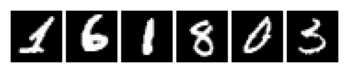

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision

import random

mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = True,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)

# Images can be plotted with matplotlib imshow
show = [mnist[i] for i in [59289, 28001, 35508, 43876, 23627, 14028]]
show = torch.stack([img for img,lbl in show])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

mnist_batched = torch.utils.data.DataLoader(mnist, batch_size=100)

# Models

## Simple d-dimensional VAE

In [21]:
class BernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))


class GaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ+σ*ε)
        return ll - kl

### Train me!

In [22]:
simple_vae = GaussianEncoder(BernoulliImageGenerator())
optimizer = optim.Adam(simple_vae.parameters())
epoch = 0

while epoch < 50:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        loglik_lb = torch.mean(simple_vae.loglik_lb(images))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")
    
    # Save the trained model, we'll reuse it for the questions.
    torch.save(simple_vae.state_dict(), 'simple_vae.pt')

epoch: 1, loglikelihood: -155.5
epoch: 2, loglikelihood: -141.5
epoch: 3, loglikelihood: -136.6
epoch: 4, loglikelihood: -134.3
epoch: 5, loglikelihood: -132.3
epoch: 6, loglikelihood: -130.9
epoch: 7, loglikelihood: -128.5
epoch: 8, loglikelihood: -128.2
epoch: 9, loglikelihood: -127.0
epoch: 10, loglikelihood: -128.0
epoch: 11, loglikelihood: -127.4
epoch: 12, loglikelihood: -126.1
epoch: 13, loglikelihood: -124.9
epoch: 14, loglikelihood: -124.9
epoch: 15, loglikelihood: -124.1
epoch: 16, loglikelihood: -123.2
epoch: 17, loglikelihood: -122.6
epoch: 18, loglikelihood: -122.4


KeyboardInterrupt: 

In [ ]:
# Save the trained model, we'll reuse it for the questions.
torch.save(simple_vae.state_dict(), 'simple_vae.pt')

## Expanded sampling d-dimensional VAE

In [24]:
class BernoulliImageGeneratorExpandedSampling(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1, 2, 3))


class GaussianEncoderExpandedSampling(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )
        self.likelihoods = {}

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, batch_num, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)

        # Running the below is equivalent to sampling just once
        # a value for Z(phi, x) for each of the data poitns in the
        # vector x. If we want multiple samples, we don't need to
        # pass through the encoder again - that will be the same,
        # given the parameters we have now. But if we sample the
        # noise epsilon again, we'll get a different Z(phi, x).
        ll = 0
        num_samples = 1
        for _ in range(num_samples):
          ε = torch.randn_like(σ)
          ll += self.f.loglik(x, z=μ+σ*ε)
        ll /= num_samples
        
        for i in range(x.shape[0]):
            self.likelihoods[i + batch_num*100] = ll[i].detach().numpy()

        # Sum up all likelihoods to find likelihood of dataset.
        return ll - kl

### Train me!

In [25]:
expanded_sampling_vae = GaussianEncoderExpandedSampling(BernoulliImageGeneratorExpandedSampling())
optimizer = optim.Adam(expanded_sampling_vae.parameters())
epoch = 0

while epoch < 5:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        loglik_lb = torch.mean(expanded_sampling_vae.loglik_lb(batch_num, images))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")
    torch.save(expanded_sampling_vae.state_dict(), 'expanded_sampling_vae.pt')

epoch: 1, loglikelihood: -160.0
epoch: 2, loglikelihood: -144.7
epoch: 3, loglikelihood: -139.6
epoch: 4, loglikelihood: -136.3
epoch: 5, loglikelihood: -132.9


In [61]:
with torch.no_grad():
    loglik_lb = 0
    for batch_num, (images, labels) in enumerate(batched_holdout_set):
        loglik_lb += torch.mean(expanded_sampling_vae.loglik_lb(batch_num, images))
    print(loglik_lb/batch_num)
    


tensor(-171.2684)


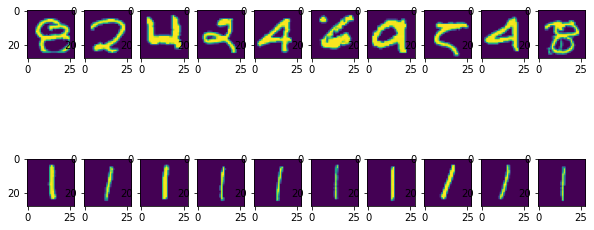

In [23]:
# Sort this dictionary for ascending likelihood.
sorted_likelihoods = list(sorted(expanded_sampling_vae.likelihoods.items(), key = lambda item: item[1]))
unlikely_images = []
likely_images = []

# Get mnist[i] for the bottom-most i and for the top-most i
for index in sorted_likelihoods[:10]:
    im, _ = mnist[index[0]]
    unlikely_images.append(im[0])
    
for index in sorted_likelihoods[-10:]:
    im, _ = mnist[index[0]]
    likely_images.append(im[0])
    
# Look at them - what do they look like?
fig = plt.figure(figsize=(10, 10))

for i in range(len(unlikely_images)):
    fig.add_subplot(2, 10, i+1)
    plt.imshow(unlikely_images[i])
    fig.add_subplot(1, 10, i+1)
    plt.imshow(likely_images[i])

In [7]:
# Save the trained model, we'll reuse it for the questions.
torch.save(expanded_sampling_vae.state_dict(), 'expanded_sampling_vae.pt')

## VAE with image-label pairs as input

In [24]:
def one_hot_encode(y, num_classes):
    encoded = torch.zeros(len(y), num_classes)
    for i in range(len(y)):
        encoded[i, y[i]-1] = 1
    return encoded

In [25]:
class BernoulliImageGeneratorWithStyleCapture(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d + 10, 128),           # TODO: this is where we would have d + num_classes
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z, y):
        # Coerce z and y into a shape that we can feed to the network.
        # z is 100x4, y is 100x10

        z = torch.cat([z, y], dim=1)
        
        return self.f(z)

    def loglik(self, x, z, y):
        xr = self(z, y)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))


class GaussianEncoderWithStyleCapture(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(2, 32, 3, 1),          # There are now two channels to account for the added label.
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x, y):
        
        # TODO: Coerce x and y into a form that we can input into the network.
        # Encode y as a 1x28x28, then stack it as an extra channel in the image.
        # So updated y is 100x1x28x28.
        transform_labels = nn.Linear(10, 784)
        
        y_transformed = [transform_labels(y_i) for y_i in y]
        y_transformed = torch.tensor([y_i.view(1, 28, 28).detach().numpy() for y_i in y_transformed]) # Reshaped to Bx1x28x28. Do I need to unsqueeze here given y is already batched?
        
        x = torch.cat([x, y_transformed], dim=1)
        
        mu_tau = self.g(x)
        mu, tau = mu_tau[:,:self.d], mu_tau[:,self.d:]
        return mu, torch.exp(tau/2)

    def loglik_lb(self, x, y):
        """x is 100x1x28x28. y is 100x10 (one-hot encoded class labels)"""
        
        mu, sigma = self(x, y)
        
        kl = 0.5 * (mu**2 + sigma**2 - torch.log(sigma**2) - 1).sum(1)
        
        # Sampling from epsilon is equivalent to generating multiple Z~.
        epsilon = torch.randn_like(sigma)
        z = mu + sigma*epsilon
        
        ll = self.f.loglik(x, z, y)
        return ll - kl

In [4]:
autoencoder = GaussianEncoderWithStyleCapture(BernoulliImageGeneratorWithStyleCapture(4))
optimizer = optim.Adam(autoencoder.parameters())
epoch = 0

while epoch < 30:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        labels = one_hot_encode(labels, 10)
        loglik_lb = torch.mean(autoencoder.loglik_lb(images, labels))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")
    
    torch.save(autoencoder.state_dict(), 'cvae.pt')

epoch: 1, loglikelihood: -146.1
epoch: 2, loglikelihood: -132.3
epoch: 3, loglikelihood: -126.5
epoch: 4, loglikelihood: -123.3
epoch: 5, loglikelihood: -121.6
epoch: 6, loglikelihood: -120.9
epoch: 7, loglikelihood: -120.9
epoch: 8, loglikelihood: -119.2
epoch: 9, loglikelihood: -121.6
epoch: 10, loglikelihood: -118.3
epoch: 11, loglikelihood: -117.6
epoch: 12, loglikelihood: -116.5
epoch: 13, loglikelihood: -116.1
epoch: 14, loglikelihood: -115.6
epoch: 15, loglikelihood: -115.0
epoch: 16, loglikelihood: -114.7
epoch: 17, loglikelihood: -115.2
epoch: 18, loglikelihood: -114.6
epoch: 19, loglikelihood: -114.5
epoch: 20, loglikelihood: -114.0
epoch: 21, loglikelihood: -113.9
epoch: 22, loglikelihood: -113.6
epoch: 23, loglikelihood: -114.3
epoch: 24, loglikelihood: -114.2
epoch: 25, loglikelihood: -112.8
epoch: 26, loglikelihood: -112.9
epoch: 27, loglikelihood: -112.6
epoch: 28, loglikelihood: -113.2
epoch: 29, loglikelihood: -111.7
epoch: 30, loglikelihood: -112.7


# Helper functions

## Save a model

In [5]:
torch.save(autoencoder.state_dict(), 'cvae.pt')

## Load a saved model

In [26]:
autoencoder = GaussianEncoderWithStyleCapture(BernoulliImageGeneratorWithStyleCapture(4))
autoencoder.load_state_dict(torch.load("cvae.pt"))

<All keys matched successfully>

## Generate a random sample

In [38]:
y_encoded[0].unsqueeze(-1).T.shape

torch.Size([1, 10])

4


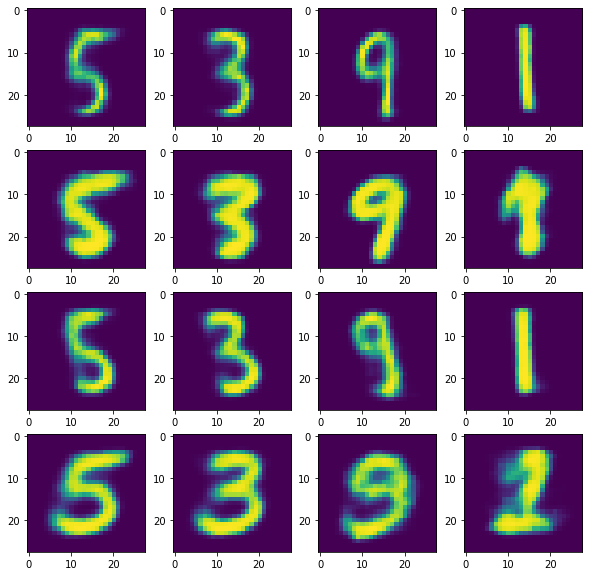

In [53]:
y = [5, 3, 9, 1]
y_encoded = one_hot_encode(y, 10)
all_images = []

for _ in range(4):
    z = torch.randn(4).unsqueeze(1).T
    all_images.append([autoencoder.f(z, y_i.unsqueeze(1).T).detach().numpy() for y_i in y_encoded])

print(len(all_images[0]))
fig = plt.figure(figsize=(10, 10))
for j in range(len(all_images)):
    for i in range(len(all_images[j])):
        fig.add_subplot(len(all_images[j]), len(all_images), 4*j+(i+1))
        plt.imshow(all_images[j][i][0][0])

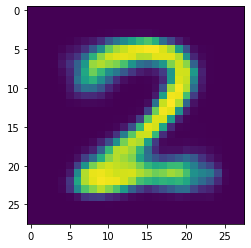

In [19]:
y = [2]
y_t = one_hot_encode(y, 10)


rec_image = autoencoder.f(z, y_t).detach().numpy()

plt.imshow(rec_image[0][0])

In [89]:
img, lbl = mnist[random.randrange(0, len(mnist))]

print(lbl)

# Need to reshape to (1, 1, 28, 28) because this VAE works on batches.
mu, sigma = autoencoder(img.reshape((1, 1, 28, 28))) 
z = mu + sigma * torch.randn_like(sigma)

gen_img = simple_vae.f(z)

1


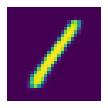

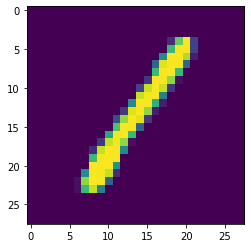

In [90]:
fig = plt.figure(figsize=(10, 10))
plot_images(fig, gen_img)
plt.imshow(img[0])

## Plot multiple images

In [40]:
def plot_images(fig, images):
    images = [image.detach().numpy()[0] for image in images]
    for i in range(len(images)):
        fig.add_subplot(5, 5, i+1)
        plt.imshow(images[i])
        
    plt.axis('off')
    plt.show()

In [6]:
z = torch.randn((100, 4))

z.shape

torch.Size([100, 4])

In [19]:
x = torch.zeros((1, 10))
y = torch.ones((1, 10))

x, y

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

In [20]:
res = []
x, y = x.detach().numpy(), y.detach().numpy()
for i in range(x.shape[1]):
    res.append((x[0][i], y[0][i]))
    
torch.tensor(res)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [42]:
def get_greyscale(image):
    img = image.detach().numpy()
    return 784-np.count_nonzero(img < 0.2)-np.count_nonzero(img > 0.7)

count_greyscale = [get_greyscale(img) for (img, _) in mnist]

In [55]:
cts = [i for i in range(len(mnist))]
d = dict(zip(cts, count_greyscale))

d = list(sorted(d.items(), key=lambda item : item[1]))

blurry_digits = [index for index, value in d[-12000:]]

[24937,
 24960,
 24962,
 24968,
 24976,
 25004,
 25040,
 25082,
 25094,
 25182,
 25183,
 25224,
 25271,
 25301,
 25306,
 25342,
 25445,
 25550,
 25583,
 25619,
 25711,
 25755,
 25763,
 25807,
 25839,
 25911,
 25912,
 25916,
 26003,
 26046,
 26300,
 26319,
 26343,
 26386,
 26436,
 26447,
 26449,
 26508,
 26538,
 26565,
 26574,
 26633,
 26637,
 26778,
 26782,
 26843,
 26893,
 26947,
 26955,
 26973,
 26999,
 27024,
 27031,
 27052,
 27113,
 27127,
 27135,
 27192,
 27210,
 27235,
 27261,
 27286,
 27328,
 27348,
 27361,
 27470,
 27533,
 27548,
 27618,
 27637,
 27696,
 27715,
 27779,
 27865,
 27899,
 27903,
 27905,
 27947,
 27994,
 28010,
 28028,
 28054,
 28151,
 28156,
 28181,
 28253,
 28406,
 28440,
 28451,
 28490,
 28550,
 28579,
 28644,
 28662,
 28689,
 28705,
 28734,
 28809,
 28810,
 28843,
 28879,
 28889,
 28904,
 28940,
 29023,
 29053,
 29073,
 29096,
 29116,
 29135,
 29175,
 29221,
 29344,
 29521,
 29524,
 29570,
 29606,
 29613,
 29621,
 29629,
 29637,
 29648,
 29674,
 29745,
 29753,


In [58]:
training_set = [mnist[index] for index in range(len(mnist)) if index not in blurry_digits]
holdout_set = [mnist[index] for index in range(len(mnist)) if index in blurry_digits]

batched_training_set = torch.utils.data.DataLoader(training_set, batch_size=100)
batched_holdout_set = torch.utils.data.DataLoader(holdout_set, batch_size=100)